In [151]:
!pip install pyspark

In [152]:
import pandas as pd
import numpy as np
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, count, isnan, lit
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline, pipeline
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import time
import psutil
import matplotlib.pyplot as plt
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [153]:
# Initialize Spark Session
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

In [154]:
# Load dataset
df = spark.read.csv("/content/drive/MyDrive/HealthCareStroke_Dataset.csv", header=True, inferSchema=True)

In [155]:
# Display schema and initial data from third dataset
df.printSchema()
df.show(5)

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|  

In [156]:
#1. Handling Missing Values
#a. Drop rows where all selected columns are null
df = df.dropna(how="all")
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [157]:
#Impute missing values
age_mode = df.groupBy("age").count().orderBy(col("count").desc()).first()["age"]
df = df.fillna({'age': age_mode})
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [158]:
#b. Impute missing values
bmi_mode = df.groupBy("bmi").count().orderBy(col("count").desc()).first()["bmi"]
df = df.fillna({'bmi': bmi_mode})
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [159]:
avg_glucose_level_mode = df.groupBy("avg_glucose_level").count().orderBy(col("count").desc()).first()["avg_glucose_level"]
df = df.fillna({'avg_glucose_level': avg_glucose_level_mode})
df.show()

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [160]:
#2. Ensuring Consistent Data Types
df = df.withColumn("age", col("age").astype(DoubleType()))
df = df.withColumn("bmi", col("bmi").astype(DoubleType()))
df = df.withColumn("avg_glucose_level", col("avg_glucose_level").astype(DoubleType()))
df = df.withColumn("stroke", col("stroke").astype(IntegerType()))

print("\nData types after correction:")
print(df.dtypes)


Data types after correction:
[('id', 'int'), ('gender', 'string'), ('age', 'double'), ('hypertension', 'int'), ('heart_disease', 'int'), ('ever_married', 'string'), ('work_type', 'string'), ('Residence_type', 'string'), ('avg_glucose_level', 'double'), ('bmi', 'double'), ('smoking_status', 'string'), ('stroke', 'int')]


In [161]:
#3. Handling Categorical Anomalies
#defining categorical columns
categorical_columns = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]

#converting strings to numbers
indexers = [StringIndexer(inputCol=col, outputCol= col+ "_indexed", handleInvalid="keep") for col in categorical_columns]

#converting numbers to one hot encoder
encoders = [OneHotEncoder(inputCol=col+ "_indexed", outputCol= col+ "_encoded") for col in categorical_columns]

In [162]:
#4. Addressing Class Imbalance
stroke_ratio = df.filter(col("stroke") == 1).count() / df.count()
df = df.withColumn("weight", when(col("stroke") == 1, 1.0/stroke_ratio).otherwise(1.0/(1-stroke_ratio)))

In [163]:
# Feature Engineering
feature_cols = ["age", "bmi", "avg_glucose_level"] + [col+ "_encoded" for col in categorical_columns]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="keep")
classifier = RandomForestClassifier(featuresCol="features", labelCol="stroke", weightCol="weight")

In [164]:
# Pipeline
pipeline = Pipeline(stages= indexers + encoders + [assembler, classifier])

# Train Test Split
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

In [165]:
train_df = train_df.dropna(subset=["age", "bmi", "avg_glucose_level"])
test_df = test_df.dropna(subset=["age", "bmi", "avg_glucose_level"])

In [166]:
model= pipeline.fit(train_df)
results = model.transform(test_df)

In [167]:
# Show Results
results.select("stroke", "prediction").show(10)

+------+----------+
|stroke|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     0|       1.0|
|     1|       1.0|
|     0|       0.0|
|     0|       1.0|
+------+----------+
only showing top 10 rows



In [168]:
#Evaluation usi
evaluator = BinaryClassificationEvaluator(labelCol="stroke", rawPredictionCol="prediction")
auc = evaluator.evaluate(results)
print(f"AUC:", {auc})

AUC: {0.7091009765428369}


In [169]:
#Accuracy metrics
correct_preds = results.filter(col("stroke") == col("prediction")).count()
total_preds = results.count()
accuracy = correct_preds / total_preds
print(f"Accuracy:", {accuracy})

Accuracy: {0.7750791974656811}


In [170]:
#Evaluation with Precision Metrics
evaluator = MulticlassClassificationEvaluator(
    labelCol="stroke",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
#Calculating precision
precision = evaluator.evaluate(results)
print(f"Precision: {precision:.4f}")

Precision: 0.9382


In [171]:
labels = [str(i) for i in range(10)]

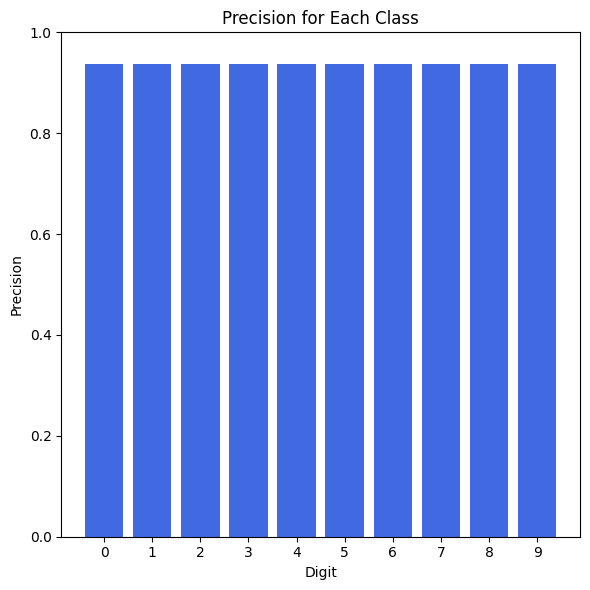

In [172]:
# Plot Precision
x = np.arange(len(labels))  # X axis locations
fig, ax = plt.subplots(figsize=(6, 6))
# Precision Plot
ax.bar(x, precision, color='royalblue')
ax.set_title('Precision for Each Class')
ax.set_xlabel('Digit')
ax.set_ylabel('Precision')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

In [173]:
#Calculating Recall Metrics
recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="stroke",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(results)
print(f"Recall: {recall:.4f}")

Recall: 0.7751


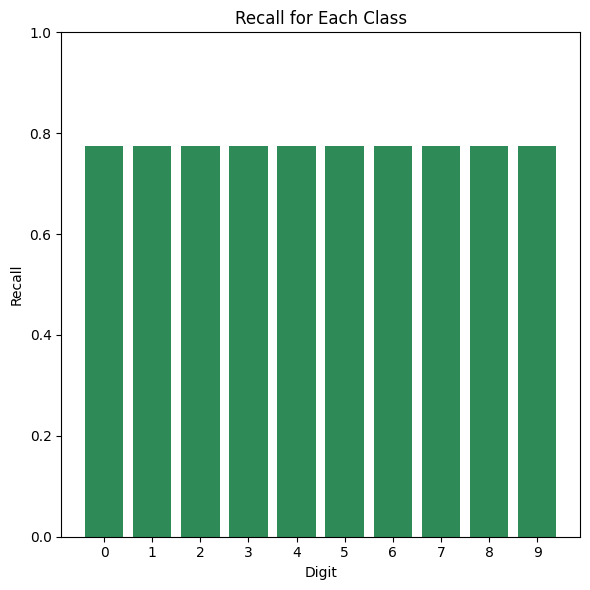

In [174]:
# Recall Plot
x = np.arange(len(labels))  # X axis locations
fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(x, recall, color='seagreen')
ax.set_title('Recall for Each Class')
ax.set_xlabel('Digit')
ax.set_ylabel('Recall')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [175]:
#Calculating F-1 Score
f1_evaluator = MulticlassClassificationEvaluator(
    labelCol="stroke",
    predictionCol="prediction",
    metricName="f1"
)
f1_score = f1_evaluator.evaluate(results)
print(f"F1 Score: {f1_score:.4f}")

F1 Score: 0.8382


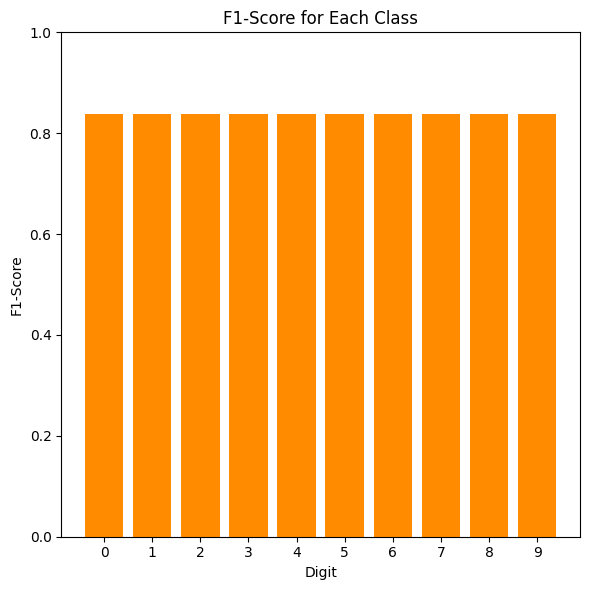

In [176]:
# F1-Score Plot
x = np.arange(len(labels))  # X axis locations
fig, ax = plt.subplots(figsize=(6, 6))

ax.bar(x, f1_score, color='darkorange')
ax.set_title('F1-Score for Each Class')
ax.set_xlabel('Digit')
ax.set_ylabel('F1-Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()

In [177]:
print("Cleaned dataset")
print(df.show())

Cleaned dataset
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+------------------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|            weight|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+------------------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|20.522088353413654|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|NULL|   never smoked|     1|20.522088353413654|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|20.522088353413654|
|60182|Female|49.0|           0|            0|         Yes| 

In [179]:
#Save cleaned data
df.write.csv("/content/cleaned_HealthCareStroke2.csv", header=True)